# Variational Inference API Quickstart

PyMC4 now comes integrated with tensorflow probability to use Variational Inference approximations.

- Mean Field ADVI - Implemented
- Full Rank ADVI - Implemented
- Low Rank ADVI - Implemented

For a more exhaustic introduction to VI, checkout this [blog post](https://www.codingpaths.com/gsoc/variational-inference/).

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc4 as pm

from pprint import pprint

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use('arviz-darkgrid')

Let's infer $\mu$ and $\sigma$ for Normal Distribution

In [3]:
# Generating data
MU = 12
SIGMA = 2.2
data = np.random.normal(MU, SIGMA, 200)

In [4]:
@pm.model
def model():
    mu = yield pm.Normal("mu", 0, 10)
    sigma = yield pm.Exponential("sigma", 1)
    ll = yield pm.Normal("ll", mu, sigma, observed=data)

In [5]:
approx_model = model()

In [6]:
help(pm.fit)

Help on function fit in module pymc4.variational.approximations:

fit(model: Union[pymc4.coroutine_model.Model, NoneType] = None, method: Union[str, pymc4.variational.approximations.Approximation] = 'advi', num_steps: int = 10000, sample_size: int = 1, random_seed: Union[int, NoneType] = None, optimizer: Union[tensorflow.python.training.optimizer.Optimizer, tensorflow.python.keras.optimizer_v2.optimizer_v2.OptimizerV2, NoneType] = None, convergence_criterion: Union[tensorflow_probability.python.optimizer.convergence_criteria.convergence_criterion.ConvergenceCriterion, NoneType] = None, trace_params: Union[Dict[str, tensorflow.python.ops.resource_variable_ops.ResourceVariable], NoneType] = None, approx_kwargs: Union[Dict[str, Any], NoneType] = None, progressbar: bool = True, progressbar_kwargs: Union[Dict[str, Union[int, str]], NoneType] = None, **kwargs)
    Fit an approximating distribution to log_prob of the model.
    
    Parameters
    ----------
    model : :class:`Model`, option

In [7]:
mean_field = pm.fit(approx_model, num_steps=40000)

|>>>>>>>>>>>>>>>>>>>>|

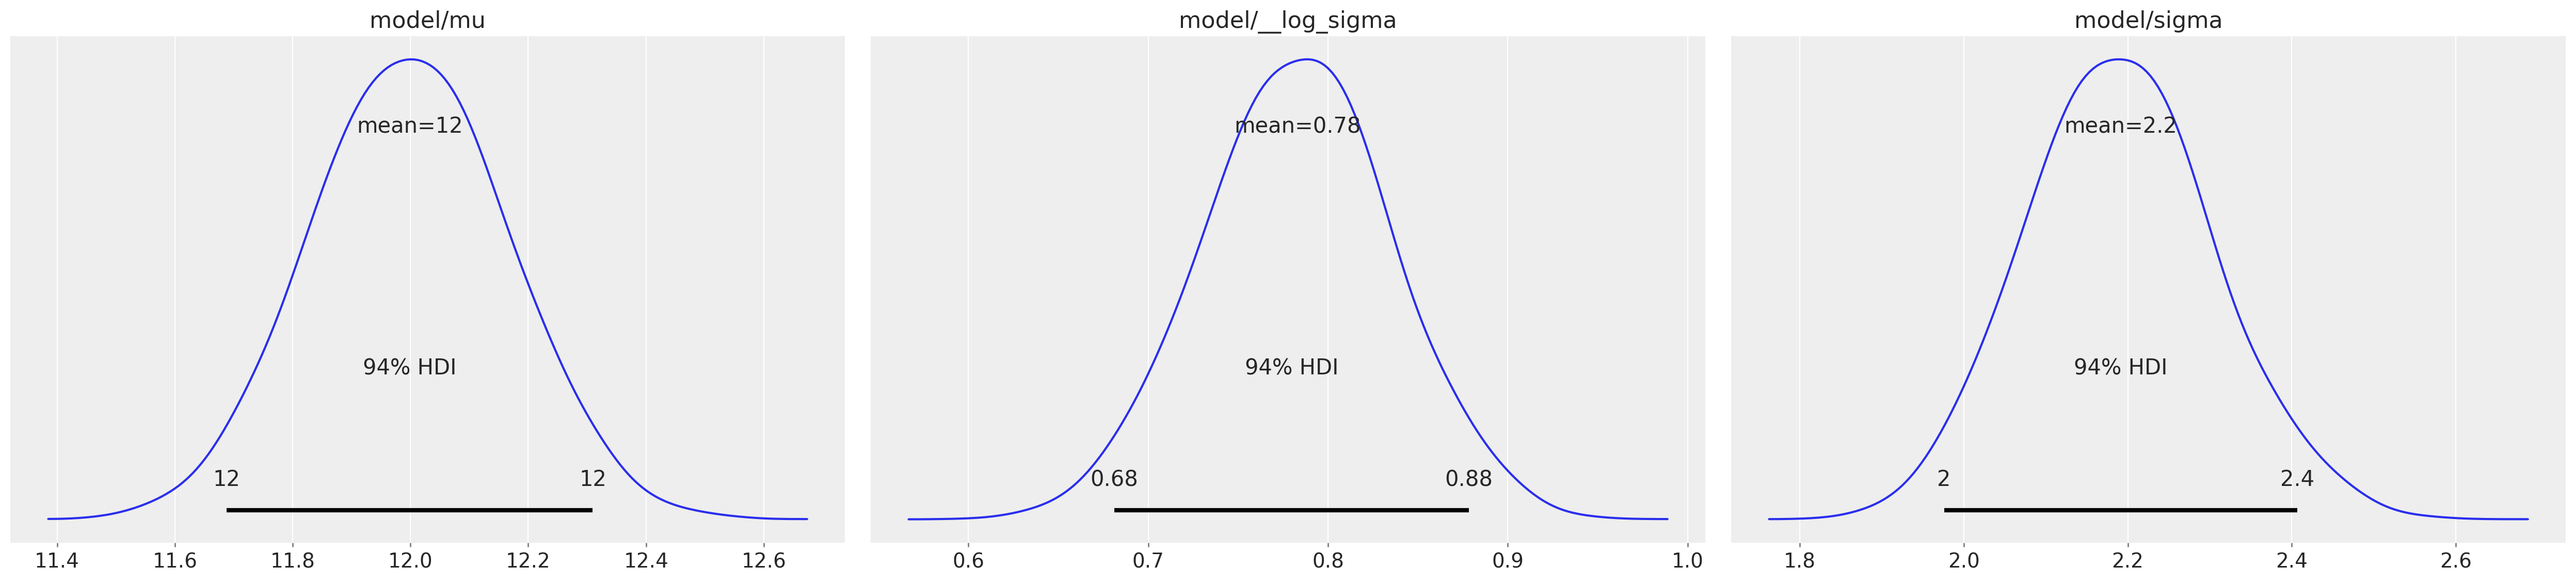

In [8]:
az.plot_posterior(mean_field.approximation.sample(10000));

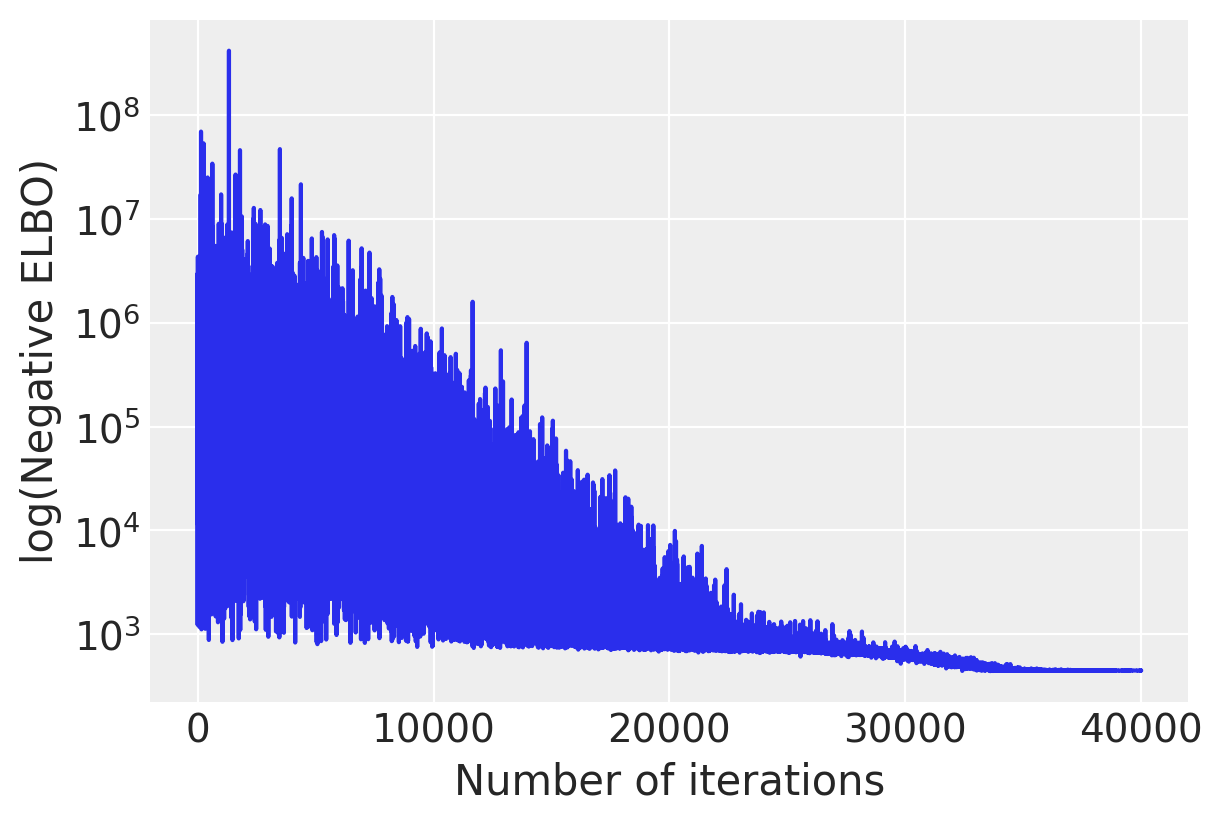

In [9]:
def plot_elbo(losses):
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, xlabel="Number of iterations",
                         ylabel="log(Negative ELBO)")
    ax.plot(losses)
    ax.set_yscale("log");


plot_elbo(mean_field.losses)

ELBO seems to have converged.

## Parameter Tracking

This is similar to `callbacks` in PyMC3.

In [10]:
approx_model = model()
advi = pm.MeanField(approx_model)

In [11]:
# Useful for NUTS sampling
pprint([advi.approx.mean(), advi.approx.stddev()])

[<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.41910535,  0.30675995], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>]


In [12]:
advi.trainable_variables
# advi.approx.shared_params in PyMC3

(<tf.Variable 'mu:0' shape=(2,) dtype=float32, numpy=array([-0.41910535,  0.30675995], dtype=float32)>,
 <tf.Variable 'sigma:0' shape=(2,) dtype=float32, numpy=array([0.54132485, 0.54132485], dtype=float32)>)

Recall for Mean Field ADVI, we approximate each parameter by Gaussian Distribution in unbounded space.

In [13]:
# track dict
track = dict()
for param in advi.trainable_variables:
    track[param.name] = param

In [14]:
mean_field = pm.fit(num_steps=40000, method=advi, trace_params=track)

|>>>>>>>>>>>>>>>>>>>>|

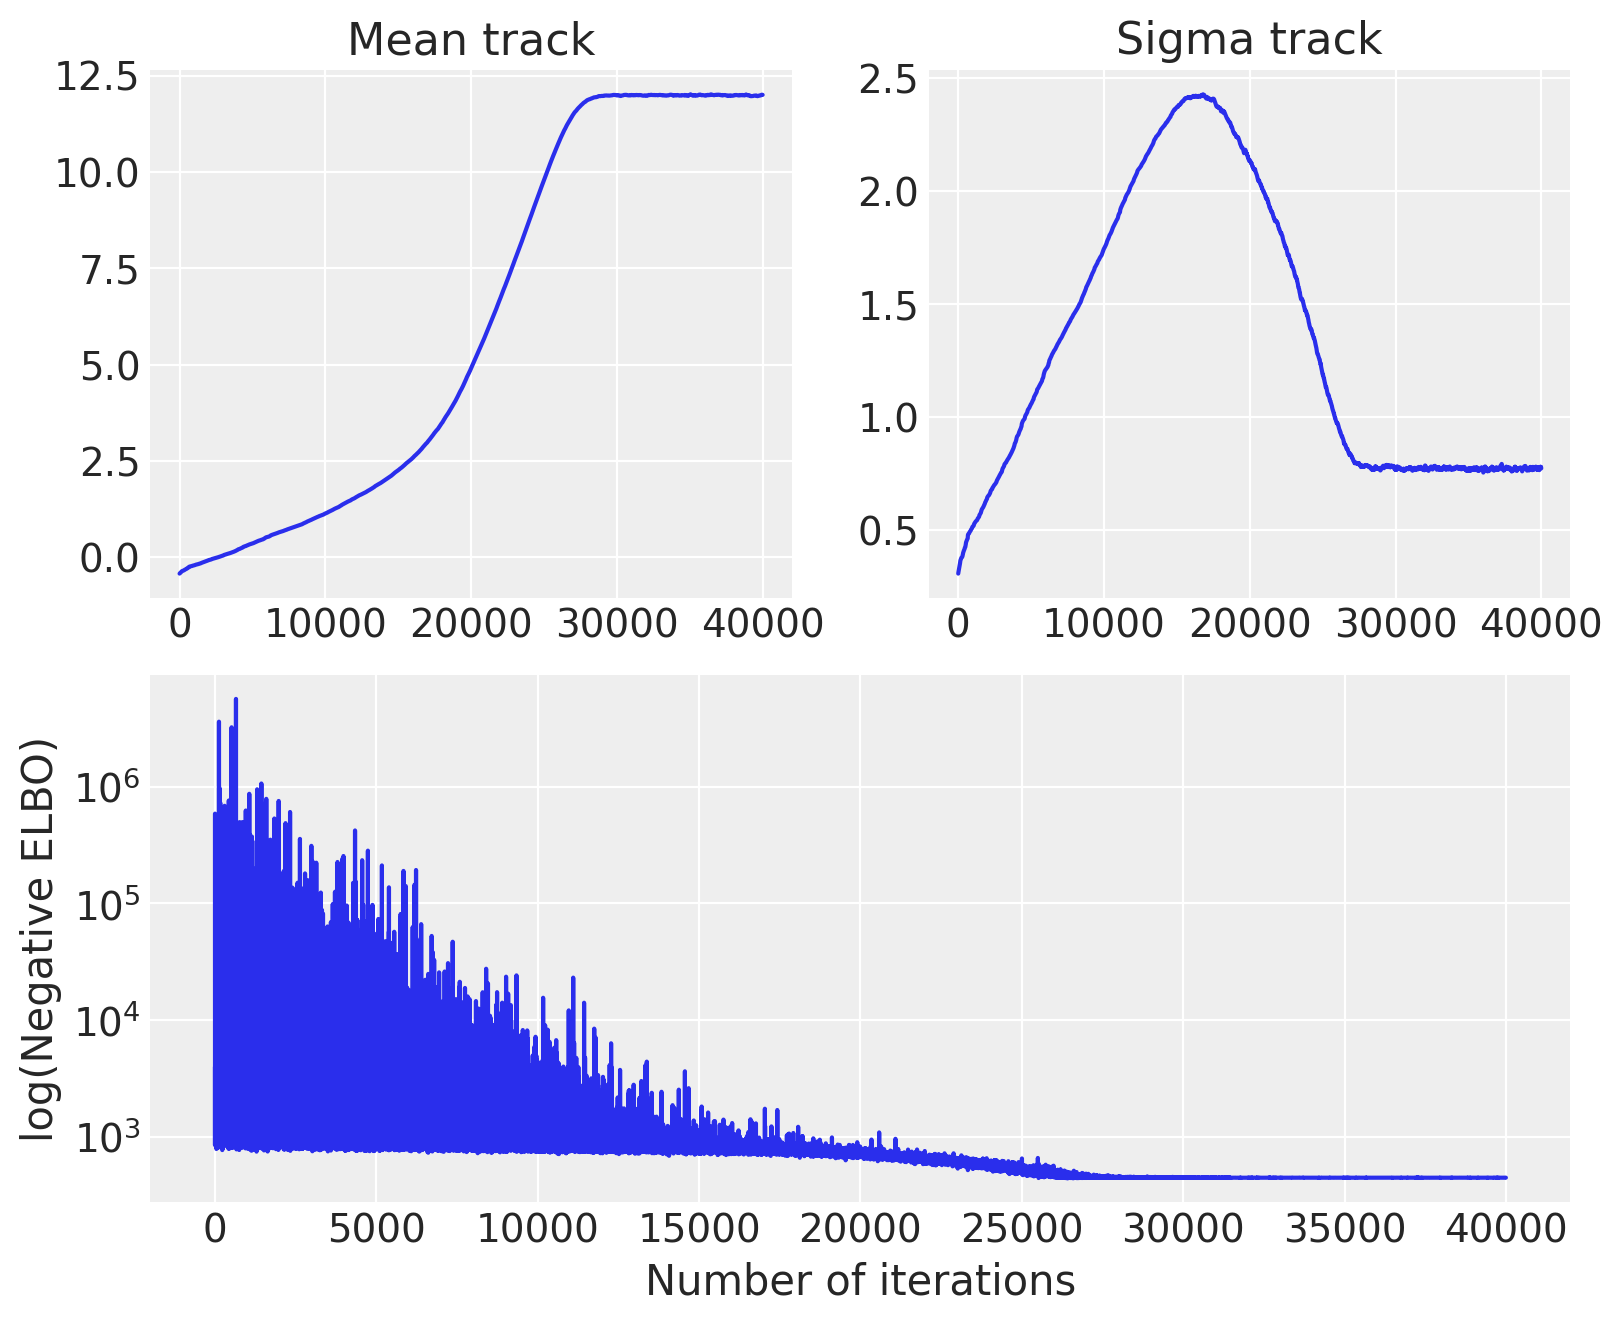

In [15]:
approximated_mu = mean_field.losses['mu:0'][:, 0]
approximated_sigma = mean_field.losses['mu:0'][:, 1]
loss = mean_field.losses["loss"]

fig = plt.figure(figsize=(8, 6.5))
gs = fig.add_gridspec(2, 2)
mu_track = fig.add_subplot(gs[0, 0])
sigma_track = fig.add_subplot(gs[0, 1])
elbo_track = fig.add_subplot(gs[1, :])

mu_track.plot(approximated_mu)
mu_track.set_title("Mean track")
sigma_track.plot(approximated_sigma)
sigma_track.set_title("Sigma track")
elbo_track.plot(loss)
elbo_track.set_xlabel("Number of iterations")
elbo_track.set_ylabel("log(Negative ELBO)")
elbo_track.set_yscale("log")

In [16]:
advi.trainable_variables

(<tf.Variable 'mu:0' shape=(2,) dtype=float32, numpy=array([11.998351  ,  0.77339554], dtype=float32)>,
 <tf.Variable 'sigma:0' shape=(2,) dtype=float32, numpy=array([-1.8060056, -2.9583087], dtype=float32)>)

We got pretty close estimates to $\mu$ and $\sigma$. Also, the parameter $\sigma$ needs to transformed via exp and that will be close to 2.2

## Checking convergence

Instances of [tfp.optimizer.convergence_criteria.ConvergenceCriterion](https://www.tensorflow.org/probability/api_docs/python/tfp/optimizer/convergence_criteria/ConvergenceCriterion) or criterias from `pm.callbacks` can be used. 

In [17]:
help(pm.callbacks.CheckParametersConvergence)

Help on class CheckParametersConvergence in module pymc4.variational.callbacks:

class CheckParametersConvergence(tensorflow_probability.python.optimizer.convergence_criteria.convergence_criterion.ConvergenceCriterion)
 |  CheckParametersConvergence(every: int = 100, tolerance: float = 0.001, diff: str = 'relative', ord=inf, min_num_steps: int = 20, name: Union[str, NoneType] = None)
 |  
 |  Parameter convergence checks.
 |  
 |  Parameters
 |  ----------
 |  every : int, default=100
 |      Check convergence after certain number of iterations.
 |  tolerance : float, default=1e-3
 |      Absolute/Relative tolerance value. Convergence is assumed whenever difference
 |      between successive parameter values < tolerance.
 |  diff : {'absolute', 'relative'}, default='relative'
 |      Tolerance type.
 |  ord : {'fro', 'euclidean', 1, 2, np.inf}, default=np.inf
 |      Order of the norm. For more info, see :func:`tf.norm`.
 |  
 |  Method resolution order:
 |      CheckParametersConverge

In [18]:
# Experimenting with any tolerance values
approx_model = model()
mean_field = pm.fit(approx_model, num_steps=40000,
                    convergence_criterion=pm.callbacks.CheckParametersConvergence(tolerance=0.003))

|>>>>>>>>>>>>>>>.....|

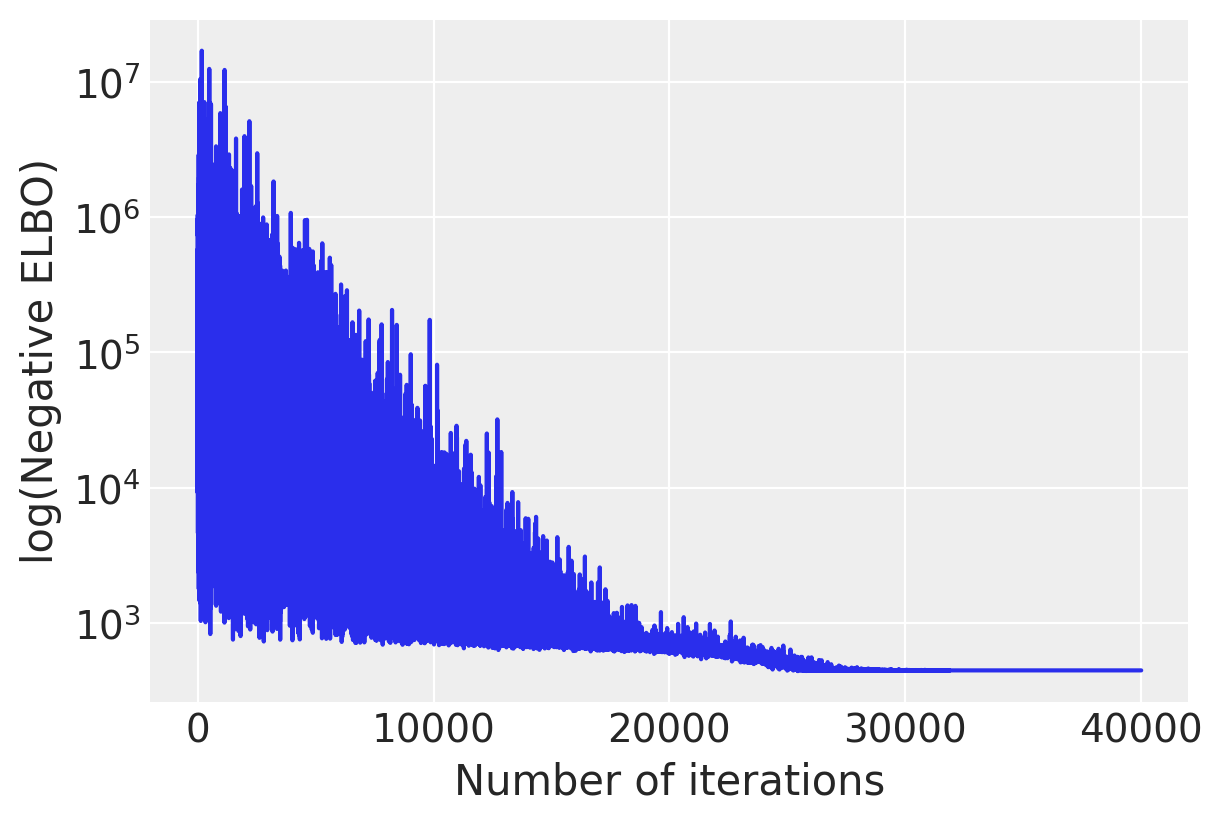

In [19]:
plot_elbo(mean_field.losses)

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w

arviz 0.9.0
pymc4 4.0a2
numpy 1.18.5
last updated: Mon Aug 17 2020 

CPython 3.7.7
IPython 7.17.0
watermark 2.0.2
